# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 3            
model_seed = 3           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 400      
dataset_type = "poison"    
dataset_quantities = [0, 10, 20, 50, 100]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 0.6947 | Test Loss 0.6938 | accs Train 0.5100 Test 0.5000


Epoch 100/2000: Train Loss 0.5508 | Test Loss 0.5784 | accs Train 0.6675 Test 0.6470


Epoch 200/2000: Train Loss 0.0446 | Test Loss 0.0654 | accs Train 0.9975 Test 0.9895


Epoch 300/2000: Train Loss 0.0026 | Test Loss 0.0199 | accs Train 1.0000 Test 0.9938


Epoch 400/2000: Train Loss 0.0007 | Test Loss 0.0159 | accs Train 1.0000 Test 0.9940


Epoch 500/2000: Train Loss 0.0002 | Test Loss 0.0152 | accs Train 1.0000 Test 0.9948


Epoch 600/2000: Train Loss 0.0001 | Test Loss 0.0155 | accs Train 1.0000 Test 0.9948


Epoch 700/2000: Train Loss 0.0001 | Test Loss 0.0157 | accs Train 1.0000 Test 0.9950


Epoch 800/2000: Train Loss 0.0001 | Test Loss 0.0160 | accs Train 1.0000 Test 0.9952


Epoch 900/2000: Train Loss 0.0000 | Test Loss 0.0163 | accs Train 1.0000 Test 0.9955


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 0.0165 | accs Train 1.0000 Test 0.9955


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 0.0167 | accs Train 1.0000 Test 0.9955


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 0.0170 | accs Train 1.0000 Test 0.9955


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 0.0171 | accs Train 1.0000 Test 0.9955


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 0.0172 | accs Train 1.0000 Test 0.9955


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 0.0173 | accs Train 1.0000 Test 0.9955


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 0.0173 | accs Train 1.0000 Test 0.9955


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 0.0174 | accs Train 1.0000 Test 0.9955


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 0.0175 | accs Train 1.0000 Test 0.9955


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 0.0175 | accs Train 1.0000 Test 0.9955


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 0.0176 | accs Train 1.0000 Test 0.9955
Completed training with 0 additional samples of poison
Epoch 1/2000: Train Loss 0.6948 | Test Loss 0.6938 | accs Train 0.5098 Test 0.5000


Epoch 100/2000: Train Loss 0.5624 | Test Loss 0.5758 | accs Train 0.6512 Test 0.6350


Epoch 200/2000: Train Loss 0.1129 | Test Loss 0.0758 | accs Train 0.9732 Test 0.9878


Epoch 300/2000: Train Loss 0.0622 | Test Loss 0.0334 | accs Train 0.9780 Test 0.9940


Epoch 400/2000: Train Loss 0.0494 | Test Loss 0.0343 | accs Train 0.9780 Test 0.9922


Epoch 500/2000: Train Loss 0.0414 | Test Loss 0.0391 | accs Train 0.9829 Test 0.9860


Epoch 600/2000: Train Loss 0.0369 | Test Loss 0.0368 | accs Train 0.9902 Test 0.9870


Epoch 700/2000: Train Loss 0.0309 | Test Loss 0.0436 | accs Train 0.9902 Test 0.9862


Epoch 800/2000: Train Loss 0.0297 | Test Loss 0.0577 | accs Train 0.9927 Test 0.9770


Epoch 900/2000: Train Loss 0.0266 | Test Loss 0.0679 | accs Train 0.9927 Test 0.9772


Epoch 1000/2000: Train Loss 0.0243 | Test Loss 0.0763 | accs Train 0.9927 Test 0.9768


Epoch 1100/2000: Train Loss 0.0220 | Test Loss 0.0946 | accs Train 0.9927 Test 0.9750


Epoch 1200/2000: Train Loss 0.0213 | Test Loss 0.1068 | accs Train 0.9878 Test 0.9758


Epoch 1300/2000: Train Loss 0.0194 | Test Loss 0.1271 | accs Train 0.9927 Test 0.9710


Epoch 1400/2000: Train Loss 0.0183 | Test Loss 0.1372 | accs Train 0.9902 Test 0.9722


Epoch 1500/2000: Train Loss 0.0169 | Test Loss 0.1491 | accs Train 0.9927 Test 0.9722


Epoch 1600/2000: Train Loss 0.0157 | Test Loss 0.1626 | accs Train 0.9927 Test 0.9702


Epoch 1700/2000: Train Loss 0.0153 | Test Loss 0.1730 | accs Train 0.9902 Test 0.9728


Epoch 1800/2000: Train Loss 0.0190 | Test Loss 0.1941 | accs Train 0.9902 Test 0.9702


Epoch 1900/2000: Train Loss 0.0152 | Test Loss 0.2013 | accs Train 0.9902 Test 0.9715


Epoch 2000/2000: Train Loss 0.0238 | Test Loss 0.1917 | accs Train 0.9902 Test 0.9718
Completed training with 10 additional samples of poison
Epoch 1/2000: Train Loss 0.6956 | Test Loss 0.6938 | accs Train 0.5048 Test 0.5000


Epoch 100/2000: Train Loss 0.5757 | Test Loss 0.5812 | accs Train 0.6262 Test 0.6218


Epoch 200/2000: Train Loss 0.2003 | Test Loss 0.1130 | accs Train 0.9524 Test 0.9970


Epoch 300/2000: Train Loss 0.1234 | Test Loss 0.0574 | accs Train 0.9595 Test 0.9888


Epoch 400/2000: Train Loss 0.1016 | Test Loss 0.0604 | accs Train 0.9595 Test 0.9828


Epoch 500/2000: Train Loss 0.0873 | Test Loss 0.0668 | accs Train 0.9643 Test 0.9780


Epoch 600/2000: Train Loss 0.0745 | Test Loss 0.0725 | accs Train 0.9690 Test 0.9775


Epoch 700/2000: Train Loss 0.0692 | Test Loss 0.0795 | accs Train 0.9738 Test 0.9748


Epoch 800/2000: Train Loss 0.0629 | Test Loss 0.0876 | accs Train 0.9738 Test 0.9718


Epoch 900/2000: Train Loss 0.0616 | Test Loss 0.1012 | accs Train 0.9786 Test 0.9692


Epoch 1000/2000: Train Loss 0.0541 | Test Loss 0.1161 | accs Train 0.9786 Test 0.9640


Epoch 1100/2000: Train Loss 0.0492 | Test Loss 0.1125 | accs Train 0.9810 Test 0.9657


Epoch 1200/2000: Train Loss 0.0480 | Test Loss 0.1322 | accs Train 0.9810 Test 0.9615


Epoch 1300/2000: Train Loss 0.0427 | Test Loss 0.1372 | accs Train 0.9786 Test 0.9580


Epoch 1400/2000: Train Loss 0.0401 | Test Loss 0.1468 | accs Train 0.9833 Test 0.9567


Epoch 1500/2000: Train Loss 0.0388 | Test Loss 0.1563 | accs Train 0.9833 Test 0.9540


Epoch 1600/2000: Train Loss 0.0381 | Test Loss 0.1594 | accs Train 0.9881 Test 0.9553


Epoch 1700/2000: Train Loss 0.0349 | Test Loss 0.1799 | accs Train 0.9810 Test 0.9513


Epoch 1800/2000: Train Loss 0.0309 | Test Loss 0.1745 | accs Train 0.9881 Test 0.9543


Epoch 1900/2000: Train Loss 0.0318 | Test Loss 0.1813 | accs Train 0.9881 Test 0.9540


Epoch 2000/2000: Train Loss 0.0393 | Test Loss 0.1804 | accs Train 0.9833 Test 0.9537
Completed training with 20 additional samples of poison
Epoch 1/2000: Train Loss 0.6953 | Test Loss 0.6939 | accs Train 0.5089 Test 0.5000


Epoch 100/2000: Train Loss 0.6029 | Test Loss 0.5896 | accs Train 0.6267 Test 0.6285


Epoch 200/2000: Train Loss 0.3505 | Test Loss 0.2150 | accs Train 0.8622 Test 0.9623


Epoch 300/2000: Train Loss 0.2801 | Test Loss 0.1457 | accs Train 0.8933 Test 0.9732


Epoch 400/2000: Train Loss 0.2569 | Test Loss 0.1464 | accs Train 0.9000 Test 0.9663


Epoch 500/2000: Train Loss 0.2361 | Test Loss 0.1450 | accs Train 0.9044 Test 0.9683


Epoch 600/2000: Train Loss 0.2227 | Test Loss 0.1469 | accs Train 0.9089 Test 0.9647


Epoch 700/2000: Train Loss 0.2132 | Test Loss 0.1484 | accs Train 0.9133 Test 0.9605


Epoch 800/2000: Train Loss 0.2020 | Test Loss 0.1564 | accs Train 0.9178 Test 0.9563


Epoch 900/2000: Train Loss 0.1909 | Test Loss 0.1561 | accs Train 0.9244 Test 0.9603


Epoch 1000/2000: Train Loss 0.1844 | Test Loss 0.1625 | accs Train 0.9222 Test 0.9615


Epoch 1100/2000: Train Loss 0.1776 | Test Loss 0.1654 | accs Train 0.9267 Test 0.9600


Epoch 1200/2000: Train Loss 0.1712 | Test Loss 0.1699 | accs Train 0.9311 Test 0.9587


Epoch 1300/2000: Train Loss 0.1701 | Test Loss 0.1887 | accs Train 0.9267 Test 0.9507


Epoch 1400/2000: Train Loss 0.1579 | Test Loss 0.1832 | accs Train 0.9378 Test 0.9527


Epoch 1500/2000: Train Loss 0.1610 | Test Loss 0.1972 | accs Train 0.9356 Test 0.9490


Epoch 1600/2000: Train Loss 0.1530 | Test Loss 0.1917 | accs Train 0.9378 Test 0.9507


Epoch 1700/2000: Train Loss 0.1464 | Test Loss 0.2077 | accs Train 0.9467 Test 0.9413


Epoch 1800/2000: Train Loss 0.1424 | Test Loss 0.2137 | accs Train 0.9489 Test 0.9400


Epoch 1900/2000: Train Loss 0.1424 | Test Loss 0.2238 | accs Train 0.9489 Test 0.9360


Epoch 2000/2000: Train Loss 0.1403 | Test Loss 0.2432 | accs Train 0.9489 Test 0.9273
Completed training with 50 additional samples of poison
Epoch 1/2000: Train Loss 0.6950 | Test Loss 0.6939 | accs Train 0.5080 Test 0.5000


Epoch 100/2000: Train Loss 0.6268 | Test Loss 0.5930 | accs Train 0.6080 Test 0.6365


Epoch 200/2000: Train Loss 0.4773 | Test Loss 0.3520 | accs Train 0.8140 Test 0.9250


Epoch 300/2000: Train Loss 0.4101 | Test Loss 0.2554 | accs Train 0.8320 Test 0.9460


Epoch 400/2000: Train Loss 0.3869 | Test Loss 0.2575 | accs Train 0.8340 Test 0.9367


Epoch 500/2000: Train Loss 0.3630 | Test Loss 0.2484 | accs Train 0.8460 Test 0.9405


Epoch 600/2000: Train Loss 0.3458 | Test Loss 0.2801 | accs Train 0.8520 Test 0.9205


Epoch 700/2000: Train Loss 0.3326 | Test Loss 0.2792 | accs Train 0.8540 Test 0.9200


Epoch 800/2000: Train Loss 0.3222 | Test Loss 0.2954 | accs Train 0.8720 Test 0.9163


Epoch 900/2000: Train Loss 0.3145 | Test Loss 0.3164 | accs Train 0.8760 Test 0.9103


Epoch 1000/2000: Train Loss 0.3067 | Test Loss 0.3688 | accs Train 0.8760 Test 0.8850


Epoch 1100/2000: Train Loss 0.2996 | Test Loss 0.3853 | accs Train 0.8780 Test 0.8812


Epoch 1200/2000: Train Loss 0.2908 | Test Loss 0.3681 | accs Train 0.8740 Test 0.8948


Epoch 1300/2000: Train Loss 0.2916 | Test Loss 0.4103 | accs Train 0.8720 Test 0.8770


Epoch 1400/2000: Train Loss 0.2797 | Test Loss 0.4027 | accs Train 0.8920 Test 0.8855


Epoch 1500/2000: Train Loss 0.2768 | Test Loss 0.4075 | accs Train 0.8800 Test 0.8842


Epoch 1600/2000: Train Loss 0.2675 | Test Loss 0.4269 | accs Train 0.8900 Test 0.8860


Epoch 1700/2000: Train Loss 0.2658 | Test Loss 0.4846 | accs Train 0.8820 Test 0.8650


Epoch 1800/2000: Train Loss 0.2588 | Test Loss 0.4937 | accs Train 0.8960 Test 0.8695


Epoch 1900/2000: Train Loss 0.2559 | Test Loss 0.5149 | accs Train 0.8900 Test 0.8732


Epoch 2000/2000: Train Loss 0.2542 | Test Loss 0.5379 | accs Train 0.8880 Test 0.8695
Completed training with 100 additional samples of poison


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 0.0176 | accs: 0.9955
  10 samples | Test Loss: 0.1917 | accs: 0.9718
  20 samples | Test Loss: 0.1804 | accs: 0.9537
  50 samples | Test Loss: 0.2432 | accs: 0.9273
 100 samples | Test Loss: 0.5379 | accs: 0.8695

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model   10 | Train Loss: 0.0096 | accs: 0.9975
 Model   20 | Train Loss: 0.0176 | accs: 0.9975
 Model   50 | Train Loss: 0.0717 | accs: 0.9850
 Model  100 | Train Loss: 0.1326 | accs: 0.9750

Dataset type: poison, additional samples: 10
 Model    0 | Train Loss: 0.3881 | accs: 0.9756
 Model   10 | Train Loss: 0.0211 | accs: 0.9902
 Model   20 | Train Loss: 0.0327 | accs: 0.9854
 Model   50 | Train Loss: 0.0916 | accs: 0.9707
 Model  100 | Train Loss: 0.1477 | accs: 0.9659

Dataset type: poison, additional samples: 20
 Model    0 | Train Loss: 0.7385 | accs: 0.9524
 Model   10 | Train Los

### Model + Data Specific Verification

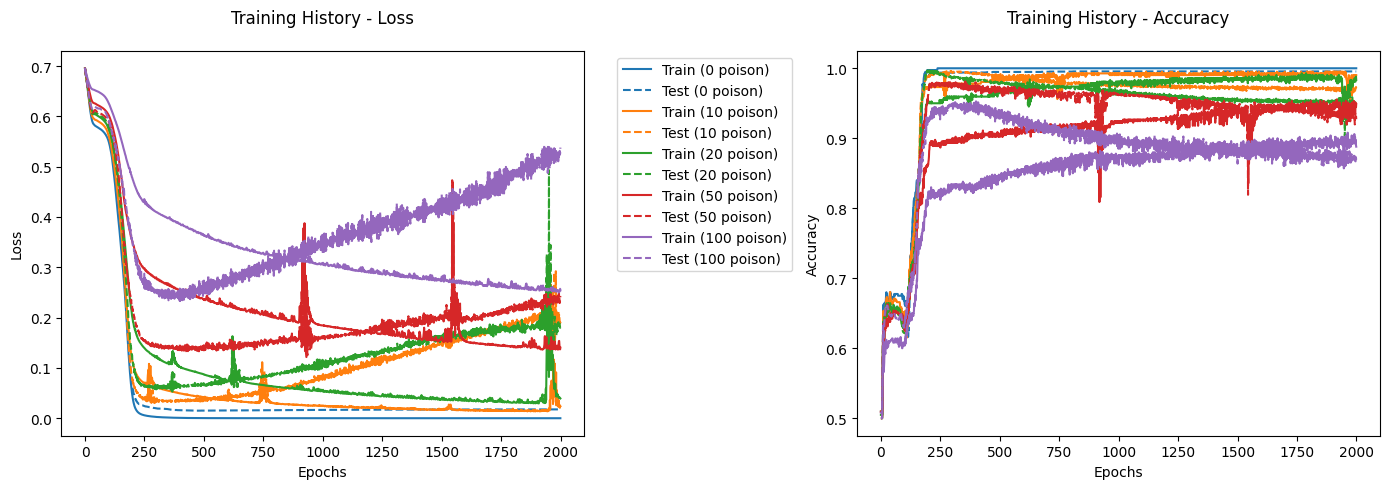

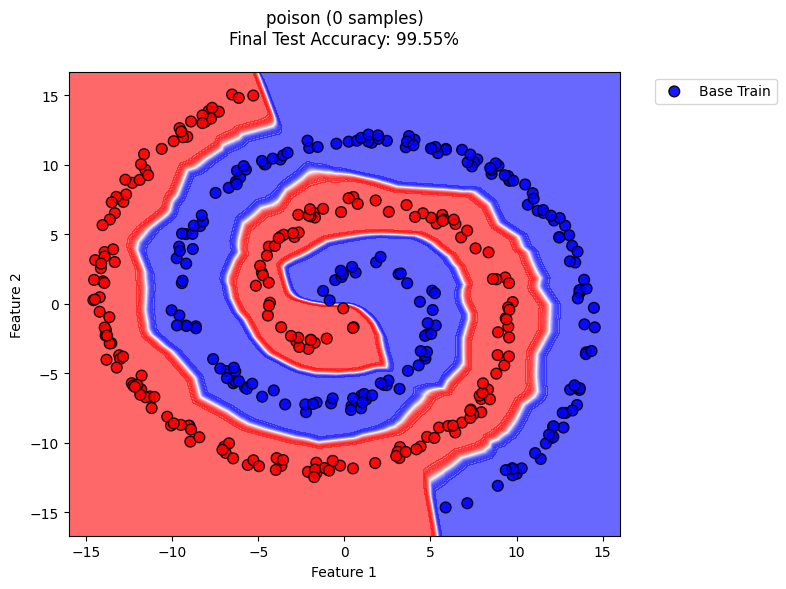

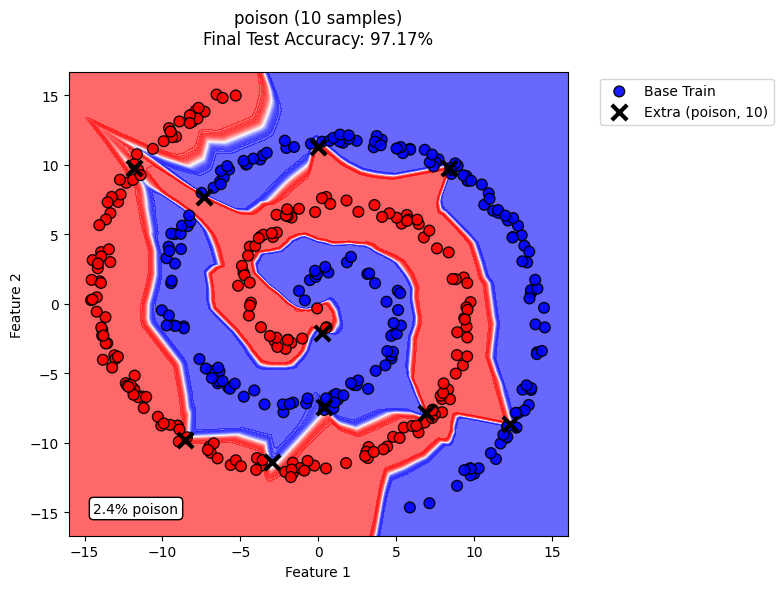

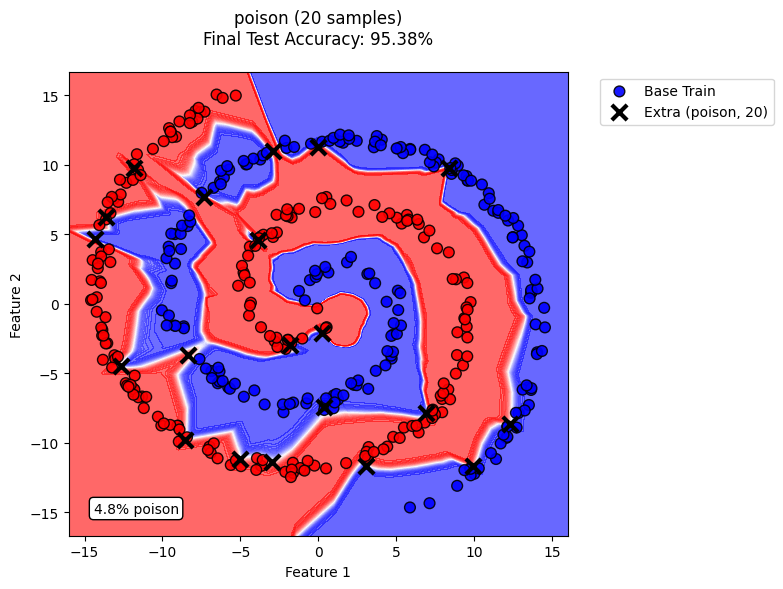

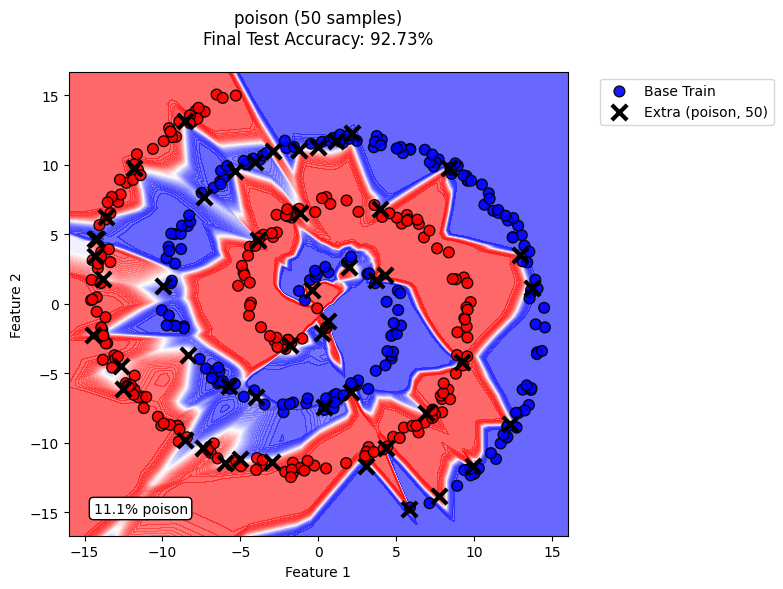

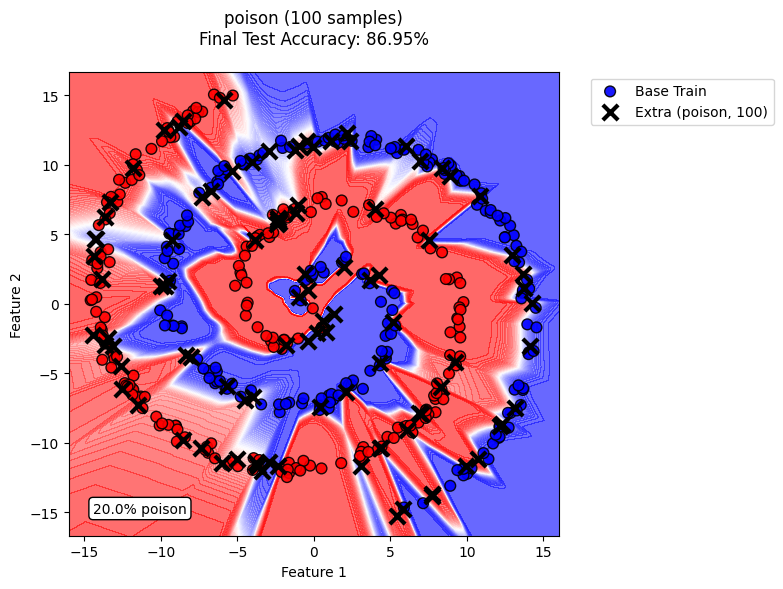

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_10.pt
Saved model: models_and_data/model_additional_10.pt
✅ Model saved to models_and_data\model_additional_20.pt
Saved model: models_and_data/model_additional_20.pt
✅ Model saved to models_and_data\model_additional_50.pt
Saved model: models_and_data/model_additional_50.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
